In [8]:
import os 

import vtk

from vtk.util.numpy_support import numpy_to_vtk, vtk_to_numpy

import numpy as np

import matplotlib.pyplot as plt




def readVTK(filename, order='F'):
            
    """
    Utility function to read vtk volume. 

    Params:

        - inherited from class (check at the beginning of the class)
        - path: path where VTK file is located
        - filename: VTK file name

    Returns:

        - numpy array
        - data origin
        - data spacing

    """

    reader = vtk.vtkStructuredPointsReader()

    reader.SetFileName(filename)

    reader.Update()

    image = reader.GetOutput()

    numpy_array = vtk_to_numpy(image.GetPointData().GetScalars())

    numpy_array = numpy_array.reshape(image.GetDimensions(),order='F')

    numpy_array = numpy_array.swapaxes(0,1)

    origin = list(image.GetOrigin())

    spacing = list(image.GetSpacing())

    return numpy_array, origin, spacing
    
    
    
def array2vtk(array, filename, dest_path, origin = [0,0,0], spacing = [1,1,1]):
                
    """
    Convert array into .vtk file

    - Params:

        inherited class parameters (see description at beginning of the class)

        array: array to be converted into .vtk file

        filename: filename with which to save array as VTK file

        origin: origin of coordinate system, by default (0,0,0)

        spacing: spacing of coordinate system, by default (1,1,1)

    """

    vtk_writer = vtk.vtkStructuredPointsWriter()


    # Check if destination folder exists

    #print('Checking if destination folder exists\n')

    isdir = os.path.isdir(dest_path)

    if not isdir:

        os.makedirs(dest_path)

        print('Non-existing destination path. Created\n')

    # Check if files already exist in destination folder

    exist = filename in os.listdir(dest_path)

    overwrite = 'y'

    if exist:

        overwrite = input("File is already in folder. Do you want to overwrite? [y/n]\n")

    if overwrite == 'y' or overwrite == 'Y':

        vtk_writer.SetFileName(dest_path + filename)

        vtk_im = vtk.vtkStructuredPoints()

        vtk_im.SetDimensions((array.shape[1],array.shape[0],array.shape[2]))

        vtk_im.SetOrigin(origin)

        vtk_im.SetSpacing(spacing)

        pdata = vtk_im.GetPointData()

        vtk_array = numpy_to_vtk(array.swapaxes(0,1).ravel(order='F'),deep = 1, array_type=vtk.VTK_FLOAT)

        pdata.SetScalars(vtk_array)

        vtk_writer.SetFileType(vtk.VTK_BINARY)

        vtk_writer.SetInputData(vtk_im)

        vtk_writer.Update()

        #print('VTK file saved successfully!\n')

    else:
        print('\nOperation aborted\n')

start_folder = '/home/andres/Documents/_Data/_Patients/'

dest_folder = '/home/andres/Documents/_Data/_Patients2D/'

modalities = sorted(os.listdir(start_folder))

for modality in modalities:
    
    if not('HM' in modality): # Discard images with histogram matching
        
        modality_path = start_folder + modality + '/'
        
        studies = sorted(os.listdir(modality_path))
        
        for study in studies:
            
            study_path = modality_path + study + '/'
            
            patients = sorted(os.listdir(study_path))
            
            for patient in patients:
                
                patient_path = study_path + patient + '/'
                
                images = sorted(os.listdir(patient_path))
                
                for image in images:
                    
                    image_path = patient_path + image
                    
                    if not('msk' in image): # Discard masks
                    
                        img_array, origin, spacing = readVTK(image_path)
                        
                        if 'mag' in image: # Magnitude or magnitude BF images
                            
                            max_img = np.amax(img_array, axis = -1)
                            
                            if 'BF' in image:
                            
                                tip = 'magBF'
                                
                            else:
                                
                                tip = 'mag'
                            
                        elif 'pha' in image: # Phase images
                            
                            max_img = np.amax(np.abs(img_array), axis = -1)
                            
                            tip = 'pha'
                            
                        filename = image[:-4] + '_mip.vtk'
                        
                        dest_path = dest_folder + modality + '/' + study + '/' + patient + '/' + tip + '/'
                        
                        max_img = np.expand_dims(max_img, -1)
                        
                        array2vtk(max_img, filename, dest_path, origin, spacing)

/home/andres/anaconda3/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


/home/andres/Documents/_Data/_Patients2D/_Raw/_hero/20190731/pha/
(256, 256, 1)


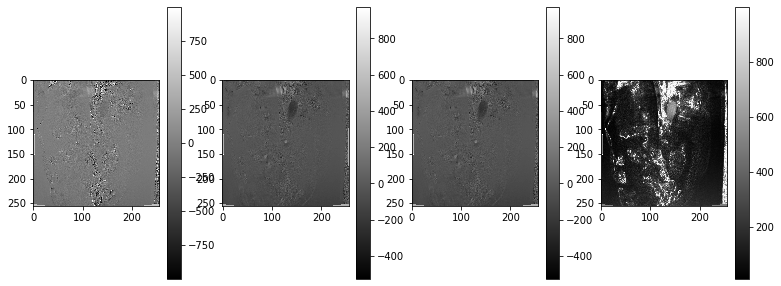

In [7]:
plt.figure(figsize = (13,5))

plt.subplot(141)

plt.imshow(img_array[:,:,0],cmap = 'gray'), plt.colorbar()


plt.subplot(142)

plt.imshow(np.mean(img_array, axis = -1), cmap = 'gray'), plt.colorbar()

plt.subplot(143)

plt.imshow(np.sum(img_array, axis = -1)/40, cmap = 'gray'), plt.colorbar()


plt.subplot(144)

plt.imshow(max_img, cmap = 'gray'), plt.colorbar()


print(dest_path)

print(np.expand_dims(max_img, axis = -1).shape)